<H1>Notebook for Segmentation of Blood Vessels using the DRIVE dataset</H1>

[![paper](https://img.shields.io/badge/Springer-Full_Paper-blue)](https://doi.org/10.1007/978-981-16-1543-6_16) 
[![dataset](https://img.shields.io/badge/DRIVE-Dataset-red)](https://drive.grand-challenge.org/)

<h3>1. Importing necessary libraries </h3>

In [ ]:
import cv2 as cv
import matplotlib.pyplot as plt
import numpy as np
import skimage
from skimage import data
from skimage import filters
import time
from skimage import io, morphology
from PIL import Image
from sklearn.metrics import confusion_matrix
from sklearn.metrics import roc_auc_score, auc

!python --version
cv.__version__

Python 3.7.11


'4.1.2'

<h3>2. Set Image Path variables</h3>

In [ ]:
path_to_train_images = ''                                 #Path to the directory containing the train images
path_to_test_images = ''                                  #Path to the directory containing the test images 
path_to_train_manual = ''                                 #Path to the directory containing the groundtruth/manual for train images
path_to_test_manual = ''                                  #Path to the directory containing the groundtruth/manual for test images

<h3>3. Get the train/test images </h3>

In [ ]:
def getImage_train(img_num):
  path = path_to_train_images
  name = str(img_num)+'_training.tif'                                  
  full_path = path + name
  image = cv.imread(full_path, -1)
  return image

In [ ]:
def getImage_test(img_num):
  path = path_to_test_images
  name = str(img_num - 20) + '_test.tif'
  if (img_num - 20) < 10:
    name = '0'+ name
  full_path = path + name
  image = cv.imread(full_path, -1)
  return image

<h3>4. Get the groundtruths of the train/test images </h3>

In [ ]:
def getManual_train(man_num):
  path = path_to_train_manual
  name = str(man_num)+'_manual1.gif'
  full_path = path + name
  man_gif = Image.open(full_path)
  man_gif = np.array(man_gif, dtype=np.uint8)

  return man_gif

In [ ]:
def getManual_test(man_num):
  path = path_to_test_manual
  name = str(man_num - 20)+'_test.tif'
  if (man_num - 20) < 10:
    name = '0'+ name
  full_path = path + name
  man_gif = Image.open(full_path)
  man_gif = np.array(man_gif, dtype=np.uint8)

  return man_gif

<h3>5. Resizing Images </h3>

In [ ]:
def imgResize(img):
  h = img.shape[0]
  w = img.shape[1]
  perc = 300/w
  w1 = 300
  h1 = int(h*perc)
  img_rd = img
  return img_rd

<h3>6. Alternate Sequential Filter </h3>

In [ ]:
def altSeqFilter(img):
  kernels = [(5,5), (7,7), (15,15), (11,11)]
  img_close=img.copy()
  for alt_seq in range(4):
    img_open = cv.morphologyEx(img_close, cv.MORPH_OPEN, cv.getStructuringElement(cv.MORPH_ELLIPSE,kernels[alt_seq]), iterations = 1)
    img_close = cv.morphologyEx(img_open, cv.MORPH_CLOSE, cv.getStructuringElement(cv.MORPH_ELLIPSE,kernels[alt_seq]), iterations = 1)
  return img_close

<h3>7. Noise removal </h3>

In [ ]:
def getContours1(img, thresh):
  mask1 = np.ones(img.shape, dtype="uint8") * 255	
  cnts0, hier0 = cv.findContours(img.copy(),cv.RETR_LIST,cv.CHAIN_APPROX_SIMPLE)
  for i in cnts0:
    if cv.contourArea(i) <= thresh:
      cv.drawContours(mask1, [i], -1, 0, 1)
  mask1 = cv.bitwise_and(img, img, mask = mask1)
  return mask1

<h3>8. Noise removal based on blob size </h3>

In [ ]:
def removeObjects(img, thresh):
  arr = img < 255
  img_cln = morphology.remove_small_holes(arr, area_threshold=thresh)
  img_cln = img_cln.astype('uint8')
  img_cln[img_cln == 1] = 255
  _,img_clean = cv.threshold(img_cln,20,255,cv.THRESH_BINARY_INV)
  return img_clean

<h3>9. Calculation of metrics </h3>

In [ ]:
def calc_cmat(mat):
  tn, fp, fn, tp = mat[0], mat[1], mat[2], mat[3]

  print("TP: ",tp,"\nFP: ",fp,"\nFN: ",fn,"\nTN: ",tn)

  acc = (tp+tn)/(tp+fn+fp+tn)

  spcf = tn/(tn+fp)

  sens = tp/(tp+fn)

  f1s = 2*tp/(2*tp+fp+fn)

  return acc, spcf, sens, f1s, tp, fp

<h3>10. Main code </h3>

In [ ]:
acc = []
spcf = []
sens = []
f1_sc = []
tp_list = []
fp_list = []
start_time = time.time()
for img_num in range(21,41):
  #img = getImage_train(img_num)                                                #use this for images from the train set
  img = getImage_test(img_num)                                                  #use this for images from the test set
  img = cv.cvtColor(img, cv.COLOR_BGR2RGB)
  print("Image Number: ", img_num-20)

  img_rd = imgResize(img)

  _,img_gc,_ = cv.split(img_rd)
  
  img_gc[img_gc<=30] = 0

  clahe = cv.createCLAHE(clipLimit=2.0, tileGridSize=(3,3))
  img_cl1 = clahe.apply(img_gc)

  img_alt = altSeqFilter(img_cl1)

  img_sub = cv.subtract(img_alt, img_cl1)
  clahe2 = cv.createCLAHE(clipLimit=16.0, tileGridSize=(2,2))
  img_cl2 = clahe2.apply(img_sub)

  img_mdf = cv.medianBlur(cv.GaussianBlur(img_cl2,(3,3),0), 3)

  _,img_adth = cv.threshold(img_mdf,30,255, cv.THRESH_BINARY)
  img_clth = getContours1(img_adth, 8)
  img_clth = getContours1(img_clth, 1)


  #man = getManual_train(img_num)                                               #use this for images from the train set
  man = getManual_test(img_num)                                                 #use this for images from the test set
  

  unique, counts = np.unique(man, return_counts=True)
  print("Manual", dict(zip(unique, counts)))
  img_stack = np.hstack([img_clth, man])

  mat = confusion_matrix(man.flatten(), img_clth.flatten())
  a, sp, sn, f1, tp, fp = calc_cmat(mat.flatten())
  
  

  acc.append(a*100)
  spcf.append(sp*100)
  sens.append(sn*100)
  f1_sc.append(f1*100)
  tp_list.append(tp)
  fp_list.append(fp)


fp_r = 1-np.array(spcf)/100
auc_dict = dict(zip(fp_r, sens))
auc_dict = {k: v for k, v in sorted(auc_dict.items(), key=lambda item: item[0])}
print("Accuracy List: ", acc)
print("Specificity List: ", spcf)
print("Sensitivity List: ", sens)
print("F1 Score List: ", f1_sc)
print("False Positive Rate: ", fp_r)
print(auc_dict)
print("")

end_time = time.time()

<h3>11. Metrics </h3>

In [ ]:
print("Average Accuracy = \t", sum(acc)/len(acc))
print("Average Specificity = \t", sum(spcf)/len(spcf))
print("Average Sensitivity = \t", sum(sens)/len(sens))
print("Average F1 Score = \t", sum(f1_sc)/len(f1_sc))
print(" ")

print("Total Execution Time: ", (end_time - start_time),"s")
print("Average Execution Time: ", (end_time - start_time)/len(acc),"s")

Average Accuracy = 	 95.92946114680566
Average Specificity = 	 98.31790716721112
Average Sensitivity = 	 71.18833676365432
Average F1 Score = 	 75.30504863414086
 
Total Execution Time:  6.32865047454834 s
Average Execution Time:  0.316432523727417 s


<h3>12. Plotting Metrics </h3>

Max Accuracy:  97.09601163777427 	Min Accuracy:  94.78997454236877
Max Specificity:  99.03259677376207 	Min Specificity:  97.26714238149022
Max Sensitivity:  79.2882978334734 	Min Sensitivity:  63.7065637065637
Max F1 Score:  81.91597780545804 	Min F1 Score:  71.99913018266164


<Figure size 432x288 with 0 Axes>

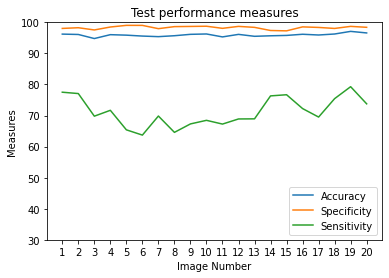

<Figure size 432x288 with 0 Axes>

In [ ]:
images   = range(1,img_num-19)
#------------------------------------------------
# Plotting Test Performance Measures per Image
#------------------------------------------------
plt.plot(images, acc, label = "Accuracy" )
plt.plot(images, spcf, label = "Specificity" )
plt.plot(images, sens, label = "Sensitivity" )
#plt.plot(images, f1_sc, label = "F1 Score" )
plt.legend(loc='lower right')
plt.xlabel("Image Number")
plt.xticks(images)
plt.ylabel("Measures")
plt.ylim(min(sens)-10,100)
plt.yticks(range(30,101,10))
plt.title ('Test performance measures')
plt.savefig('DRIVE_Test_Performance_Measures.png', dpi=100)
plt.figure()

In [ ]:
print("Standard Deviation: ")
print("ACCURACY STD: ", np.std(acc))
print("SPECIFICITY STD: ", np.std(spcf))
print("SENSITIVITY STD: ", np.std(sens))
print("F1 SCORE STD: ", np.std(f1_sc))

Standard Deviation: 
ACCURACY STD:  0.49454935006494777
SPECIFICITY STD:  0.5116300501002328
SENSITIVITY STD:  4.532759584356477
F1 SCORE STD:  2.578788453155208


In [ ]:
avg = (np.add(np.add(np.add(acc, spcf), sens),f1_sc))/4
print(avg)
print("Best Performing Image", np.where(avg == max(avg)))
print("Worst Performing Image", np.where(avg == min(avg)))

[86.25702217 86.84085558 82.94114879 85.88087376 83.58113695 83.14983204
 83.91345766 82.07660331 83.63548609 84.40107821 82.87902716 84.56491062
 84.11309328 85.36046113 85.0876274  86.21346414 84.44429113 85.39041927
 89.52382579 86.02286577]
Best Performing Image (array([18]),)
Worst Performing Image (array([7]),)
